# Voltage-gated sodium channels

Biophysical properties of voltage-gated sodium channels are important to characterize the VGSC behavior. The VGSC Nav1.7 is also a main mediator in pain syndroms, ranging from congenital insensivity to pain (CIP) for loss of function mutations to inherited erythromelalgia (IEM) and paroxysmal extreme pain disorder (PEPD) for gain of function mutations. The biophysical properties allow us to explain why patients suffer from these pain syndroms and ideally allow us to select drugs that alter these biophysical properties to ameliorate the patient's conditions.

## Load important libraries

In [1]:
import numpy as np

## Loading electrophysiological traces

In [2]:
fn = "traces.txt"

In [3]:
# Load complete file line by line and get rid of the last white space
with open(fn) as fp:
    content = [line.strip() for line in fp.readlines()]

In [4]:
content[:2]

['-120,0.051981,10.80,0;-120,-0.030111,10.80,0;-120,0.0014655,10.80,0;-120,0.067361,10.80,0;-120,-0.049222,10.80,0;-120,-0.032352,10.80,0;-120,0.017486,10.80,0;-120,0.091279,10.80,0;-120,-0.032869,10.80,0;-120,-0.0098813,10.80,0;-120,0.0015353,10.80,0;-120,-0.023953,10.80,0;-120,0.0004864,10.80,0;',
 '-120,0.0098261,0.01,0;-120,0.040148,0.01,0;-120,0.063918,0.01,0;-120,-0.0091429,0.01,0;-120,-0.024241,0.01,0;-120,0.0098032,0.01,0;-120,0.019047,0.01,0;-120,-0.078904,0.01,0;-120,0.042074,0.01,0;-120,-0.045791,0.01,0;-120,-0.021884,0.01,0;-120,0.0025893,0.01,0;-120,0.076991,0.01,0;']

The data is arranged now in lines, but some data is separated by ```;``` and inside of ;-blocks, data is separated by ```,```. Steps:

* Iterate over lines
* For each line, split at ```;```, get rid of last empty element
* For each element after 1st splitting, split by ```,``` 
* For each element after 2nd splitting, convert to float number

In [5]:
data = np.asarray([float(i) for line in content for subline in line.split(";")[:-1] for i in subline.split(",")])

Data is arranged in a single line, but from the content, we know that it has to be 13 ```;``` elements in each line and 4 elements in each ```,``` block:

In [6]:
data = data.reshape(-1, 13, 4)

In [7]:
data.shape

(1533, 13, 4)

## Visualize the data

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact

* ```0```: voltage
* ```1```: current
* ```2```: don't know, maybe capacity of cell?
* ```3```: binary voltage step

In [9]:
@interact
def showTraces(voltage_step:(0,12), data_id:(0,3)):
    plt.plot(data[:, voltage_step, data_id])

interactive(children=(IntSlider(value=6, description='voltage_step', max=12), IntSlider(value=1, description='data_id', max=3), Output()), _dom_classes=('widget-interact',))

Overview

Text(0,0.5,'Inward current [nA]')

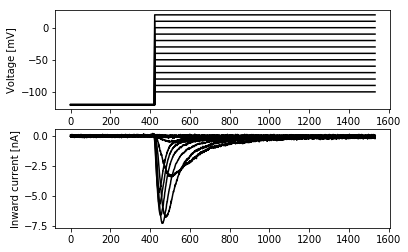

In [10]:
plt.subplot(211)
plt.plot(data[:, :, 0], c='k')
plt.ylabel("Voltage [mV]")
plt.subplot(212)
plt.plot(data[:, :, 1], c='k')
plt.ylabel("Inward current [nA]")

## Activation behavior as a major biophysical property

Identifying the maximum inward current for each voltage step

In [11]:
I = np.min(data[:, :, 1], axis=0)
V = np.max(data[:, :, 0], axis=0)

Text(0,0.5,'Inward current [nA]')

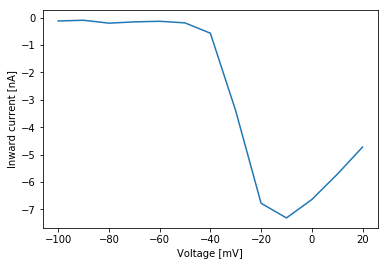

In [12]:
plt.plot(V, I)
plt.xlabel("Voltage [mV]")
plt.ylabel("Inward current [nA]")

Q: Why is the current dropping despite the fact that we activate all channels?!

A: We're getting closer to the reversal potential!

$$ I = g \cdot (V - E_{rev}), $$
where $I$ is the current, $g$ the conductance, $V$ the applied voltage and $E_{rev}$ the reversal potential.

## Calculating the reversal potential

1) Theoretically:

$$ E_{rev} = \frac{61 mV}{z} \cdot \log_{10} \frac{c[I]_{outside}}{c[I]_{inside}}, $$

where $z$ is the number of positive charges (1 for Na+), c[I] the concentration of ions outside and inside of the cell, in case of Na+ it is roughly 140 mM and 10 mM, respectively: $E_{rev}(Na+) = 69.91 mV$ 

In [13]:
61 * np.log10(140/10)

69.91381017637252

2) Experimentally

Fit a linear line to the last 3 points of the V-I curve and find the voltage where the current is 0.

### Curve fitting

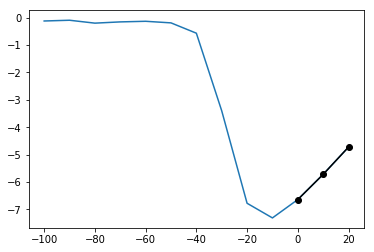

In [14]:
plt.plot(V, I)
plt.plot(V[-3:], I[-3:], c='k', marker='o')

In [15]:
# Get the last three points
x = V[-3:]
y = I[-3:]

In [16]:
from scipy.optimize import curve_fit

We would like to fit the following linear equation:

$$ y = a \cdot x + b $$

We know $x$ and $y$, and we would like to estimate the variables $a$ and $b$.

In [17]:
# Function to be fitted
def linearFunction(x, a, b):
    return a*x+b

In [18]:
a, b = curve_fit(linearFunction, x, y)[0] # Returns the estimated parameters a and b by doing ordinary least squares

In [19]:
a, b

(0.09573499999802748, -6.653050000016685)

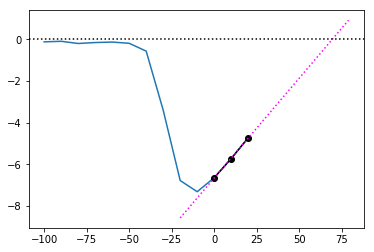

In [20]:
plt.plot(V, I)
plt.plot(V[-3:], I[-3:], c='k', marker='o')

xs = np.arange(-20, 80)
ys = a * xs + b

plt.plot(xs, ys, c='magenta', ls=':')
plt.axhline(0, ls=':', c='k')

Estimating the reversal potential:

In [21]:
E_rev = -b / a
E_rev

69.49443777253632

==> we are very close to the theoretical value!

More interesting is the conductance:

In [22]:
g = I / (V - E_rev)

Text(0.5,0,'applied voltage [mV]')

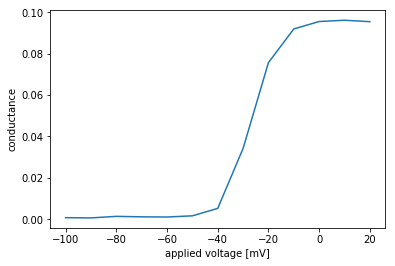

In [23]:
plt.plot(V, g)
plt.ylabel("conductance")
plt.xlabel("applied voltage [mV]")

By fitting a sigmoid function, we can figure out the slope and the shift!

Basic sigmoid:

$$ \sigma(x) = \frac{1}{1+exp(-x)} $$

In [24]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

xs = np.arange(-10, 10)
ys = sigmoid(xs)

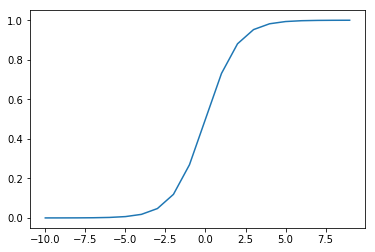

In [25]:
plt.plot(xs, ys)

We have to adjust amplitude, shift, slope, relative shift, ...

In [26]:
def sigmoid(x, A, b, c, e):
    return A * 1/(1+np.exp(-b*x+c))+e

Using ```curve_fit```...

In [27]:
p = curve_fit(sigmoid, V, g)[0]

C:\Users\me\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


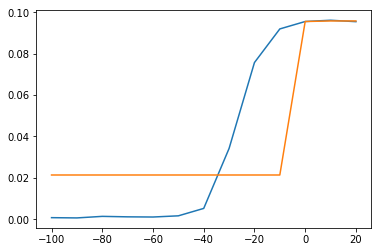

In [28]:
plt.plot(V, g)
plt.plot(V, sigmoid(V, *p))

This does not work too well, uses [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) algorithm. How about [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) or [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)?

In [29]:
from scipy.optimize import minimize

Works differently, we need to specify a loss function and ```x0``` are actually our parameters we would like to optmize

In [30]:
def helper(p, V, g):
    A, b, c, e = p
    # We minimize the mean-squared error (MSE)
    # we need to return a single number! (--> .sum()!)
    return ((g-sigmoid(V, A, b, c, e))**2).sum()

In [31]:
m = minimize(helper, [1, 1, 1, 1], args=(V, g))

In [32]:
m

      fun: 5.45172564267538e-06
 hess_inv: array([[ 2.36248899e-01, -1.06230145e+00,  3.07301933e+01,
        -8.35515573e-02],
       [-1.06230145e+00,  2.41717770e+01, -6.62463377e+02,
         3.34993789e-01],
       [ 3.07301933e+01, -6.62463377e+02,  1.90837749e+04,
        -6.99124749e+00],
       [-8.35515572e-02,  3.34993789e-01, -6.99124748e+00,
         7.58761355e-02]])
      jac: array([ 6.06107278e-07,  1.21454889e-07,  7.00282499e-09, -4.53942164e-07])
  message: 'Optimization terminated successfully.'
     nfev: 570
      nit: 48
     njev: 95
   status: 0
  success: True
        x: array([ 9.49443350e-02,  2.00407105e-01, -5.36306989e+00,  7.25668356e-04])

Parameters are now in ```m.x```

In [33]:
m.x

array([ 9.49443350e-02,  2.00407105e-01, -5.36306989e+00,  7.25668356e-04])

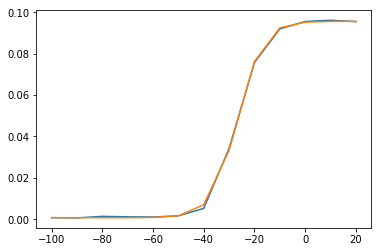

In [34]:
plt.plot(V, g)
plt.plot(V, sigmoid(V, *m.x))

Perfect!

## Exponential fit

This was not covered during the Coding Along Evening, but this is a little bonus :-)

We would like to fit an exponential function to the channel inactivation (see drawing). We use also the minimize function and determine $\tau$! 

$$f(x) = e^{\frac{-x}{\tau}}$$

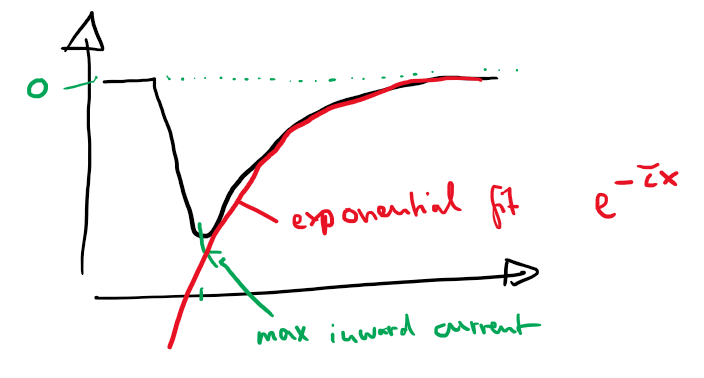

In [35]:
def exp(x, tau, a, b):
    # You can also try a * e^(-lambda*x) + b,
    # and see how it differs! tau = 1 / lambda then!
    return a * np.exp(-x/tau) + b

In [36]:
# Fit only Vs with a "significant" inward current
# Select the POSITION (argmin) of the max. inward current
Ve = V[6:]
Ix = np.argmin(data[:, :, 1], 0)[6:]

In [37]:
Ix

array([536, 502, 480, 460, 452, 447, 445], dtype=int64)

### Visualize the part that will be fitted

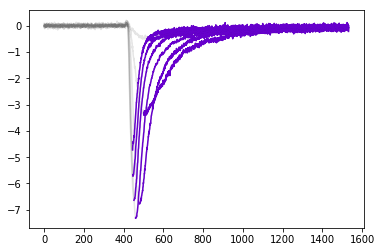

In [38]:
for cur_trace, (v,i) in enumerate(zip(Ve, Ix)):
    t = np.arange(i, data.shape[0])
    
    plt.plot(data[:, cur_trace+6, 1], c=(0,0,0,.1))    
    plt.plot(t, data[i:, cur_trace+6, 1], c=(.4, .0, .8))

### Curve fit

C:\Users\me\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


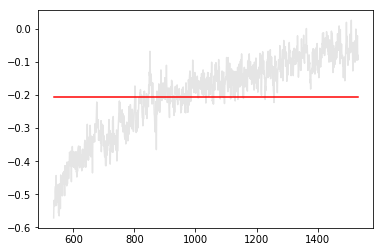

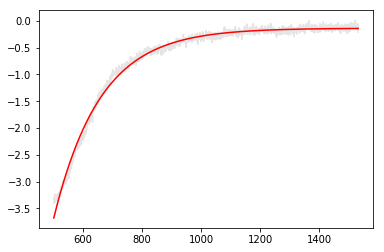

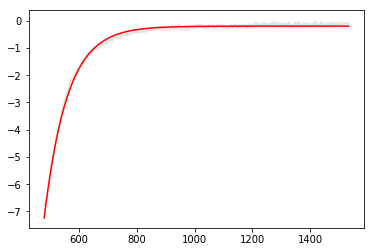

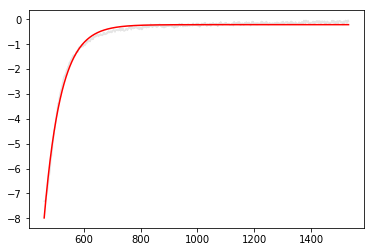

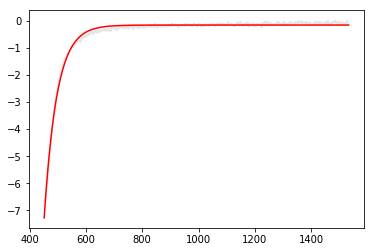

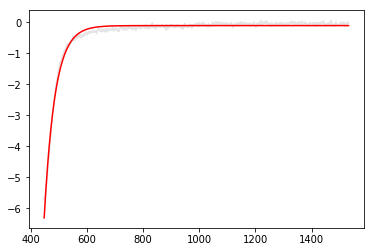

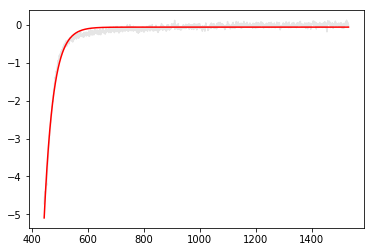

In [39]:
stop_fit = 50

for cur_trace, i in enumerate(Ix):
    xi = np.arange(i, data.shape[0])
    yi = data[i:, cur_trace+6, 1]
    
    p = curve_fit(exp, # function
                  xi[:-stop_fit], # time 
                  yi[:-stop_fit], # current
                 p0=(100., -1., -1.))[0] # init guess, tau should be >1, the amplitude and offset is for sure negative
    
    plt.figure()
    plt.plot(xi, yi, c=(0,0,0,.1))
    plt.plot(xi, exp(xi, *p), c='r')
    plt.show()
    
# Some work, some fail!    
# If you use conditions closer to the real value,
# e.g. p0=(700, -1e5, -1.) all fits will be nice! 
# Try it out!

### Minimize

In [40]:
def helper_exp(p, xi, yi): # needed for minimize
    yi_pred = exp(xi, *p)
    return ((yi-yi_pred)**2).sum()

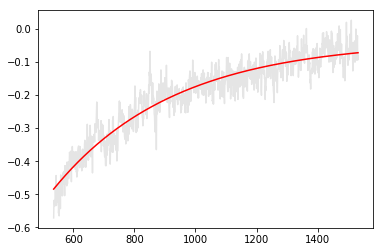

 final_simplex: (array([[ 3.95105845e+02, -1.73699794e+00, -3.67825073e-02],
       [ 3.95105845e+02, -1.73699794e+00, -3.67825073e-02],
       [ 3.95105845e+02, -1.73699794e+00, -3.67825073e-02],
       [ 3.95105845e+02, -1.73699794e+00, -3.67825073e-02]]), array([1.42293997, 1.42293997, 1.42293997, 1.42293997]))
           fun: 1.4229399699903187
       message: 'Optimization terminated successfully.'
          nfev: 489
           nit: 264
        status: 0
       success: True
             x: array([ 3.95105845e+02, -1.73699794e+00, -3.67825073e-02])


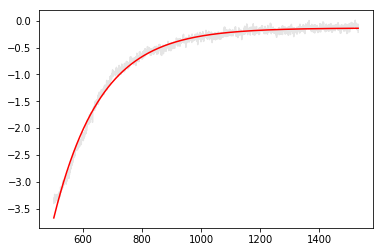

 final_simplex: (array([[ 1.57988773e+02, -8.48952943e+01, -1.34000453e-01],
       [ 1.57988773e+02, -8.48952943e+01, -1.34000453e-01],
       [ 1.57988773e+02, -8.48952942e+01, -1.34000453e-01],
       [ 1.57988773e+02, -8.48952944e+01, -1.34000453e-01]]), array([5.72320618, 5.72320618, 5.72320618, 5.72320618]))
           fun: 5.723206178682208
       message: 'Optimization terminated successfully.'
          nfev: 459
           nit: 264
        status: 0
       success: True
             x: array([ 1.57988773e+02, -8.48952943e+01, -1.34000453e-01])


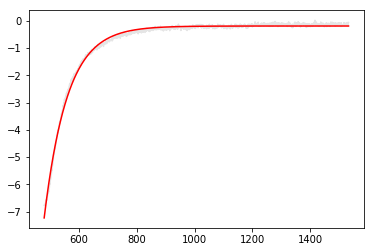

 final_simplex: (array([[ 8.01996865e+01, -2.79851937e+03, -1.92935380e-01],
       [ 8.01996865e+01, -2.79851937e+03, -1.92935380e-01],
       [ 8.01996865e+01, -2.79851937e+03, -1.92935380e-01],
       [ 8.01996865e+01, -2.79851937e+03, -1.92935380e-01]]), array([8.33309003, 8.33309003, 8.33309003, 8.33309003]))
           fun: 8.333090028357965
       message: 'Optimization terminated successfully.'
          nfev: 659
           nit: 369
        status: 0
       success: True
             x: array([ 8.01996865e+01, -2.79851937e+03, -1.92935380e-01])


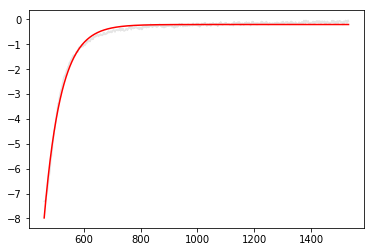

 final_simplex: (array([[ 5.91678792e+01, -1.84910201e+04, -2.04435437e-01],
       [ 5.91678792e+01, -1.84910201e+04, -2.04435437e-01],
       [ 5.91678792e+01, -1.84910201e+04, -2.04435437e-01],
       [ 5.91678792e+01, -1.84910201e+04, -2.04435437e-01]]), array([11.8589904, 11.8589904, 11.8589904, 11.8589904]))
           fun: 11.85899039502547
       message: 'Optimization terminated successfully.'
          nfev: 777
           nit: 435
        status: 0
       success: True
             x: array([ 5.91678792e+01, -1.84910201e+04, -2.04435437e-01])


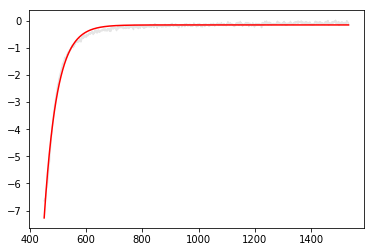

 final_simplex: (array([[ 4.50822200e+01, -1.60776474e+05, -1.58585252e-01],
       [ 4.50822200e+01, -1.60776474e+05, -1.58585252e-01],
       [ 4.50822200e+01, -1.60776474e+05, -1.58585252e-01],
       [ 4.50822200e+01, -1.60776474e+05, -1.58585252e-01]]), array([9.41906011, 9.41906011, 9.41906011, 9.41906011]))
           fun: 9.419060106540337
       message: 'Optimization terminated successfully.'
          nfev: 962
           nit: 543
        status: 0
       success: True
             x: array([ 4.50822200e+01, -1.60776474e+05, -1.58585252e-01])


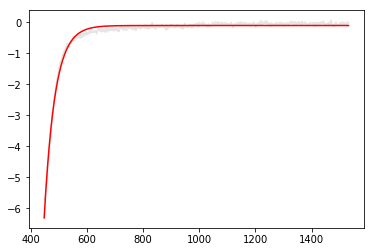

 final_simplex: (array([[ 3.84466758e+01, -6.94950088e+05, -1.04609248e-01],
       [ 3.84466758e+01, -6.94950088e+05, -1.04609248e-01],
       [ 3.84466758e+01, -6.94950088e+05, -1.04609248e-01],
       [ 3.84466758e+01, -6.94950088e+05, -1.04609248e-01]]), array([8.66761558, 8.66761558, 8.66761558, 8.66761558]))
           fun: 8.667615579028675
       message: 'Optimization terminated successfully.'
          nfev: 1043
           nit: 570
        status: 0
       success: True
             x: array([ 3.84466758e+01, -6.94950088e+05, -1.04609248e-01])


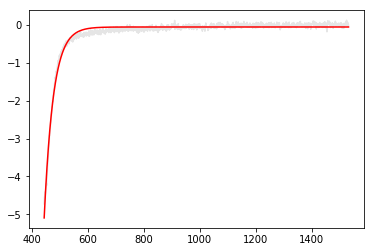

 final_simplex: (array([[ 3.26096748e+01, -4.25306605e+06, -5.56785197e-02],
       [ 3.26096748e+01, -4.25306605e+06, -5.56785197e-02],
       [ 3.26096748e+01, -4.25306605e+06, -5.56785197e-02],
       [ 3.26096748e+01, -4.25306605e+06, -5.56785197e-02]]), array([7.46672733, 7.46672733, 7.46672733, 7.46672733]))
           fun: 7.466727334265643
       message: 'Optimization terminated successfully.'
          nfev: 1167
           nit: 647
        status: 0
       success: True
             x: array([ 3.26096748e+01, -4.25306605e+06, -5.56785197e-02])


In [41]:
stop_fit = 1
taus = []

for cur_trace, i in enumerate(Ix):
    xi = np.arange(i, data.shape[0])
    yi = data[i:, cur_trace+6, 1]
    
    m = minimize(helper_exp, 
                 [100., -1., -1.], # init guess, tau should be >1, the amplitude and offset is for sure negative
                                  # not so sensitive as curve_fit
                 (xi[:-stop_fit], yi[:-stop_fit]), # x,y data pairs, in our case time and current
                 method='Nelder-Mead', # try using other methods, Nelder-Mead works here like a charm! 
                 tol=10e-8, # lower the tolerance to get better fit
                 options={'maxiter': 20000}) # more iterations to get better fit
    
    taus.append(m.x[0])
    
    plt.figure()
    plt.plot(xi, yi, c=(0,0,0,.1))
    plt.plot(xi, exp(xi, *m.x), c='r')
    plt.show()
    print(m)
    
    

Text(0.5,0,'Voltage step [mV]')

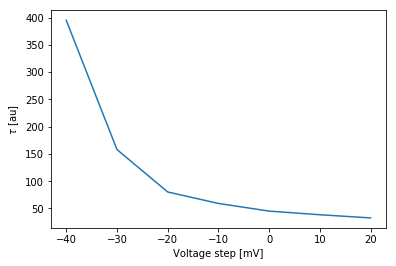

In [42]:
plt.plot(Ve, taus)
plt.ylabel(r"$\tau$ [au]")
plt.xlabel("Voltage step [mV]")

Hint: You can try to fit only a portion of the data (use ```stop_fit```) to see how this affects your fit and $\tau$!

## Gradient descent

How to write our own function to minimize a linear function!

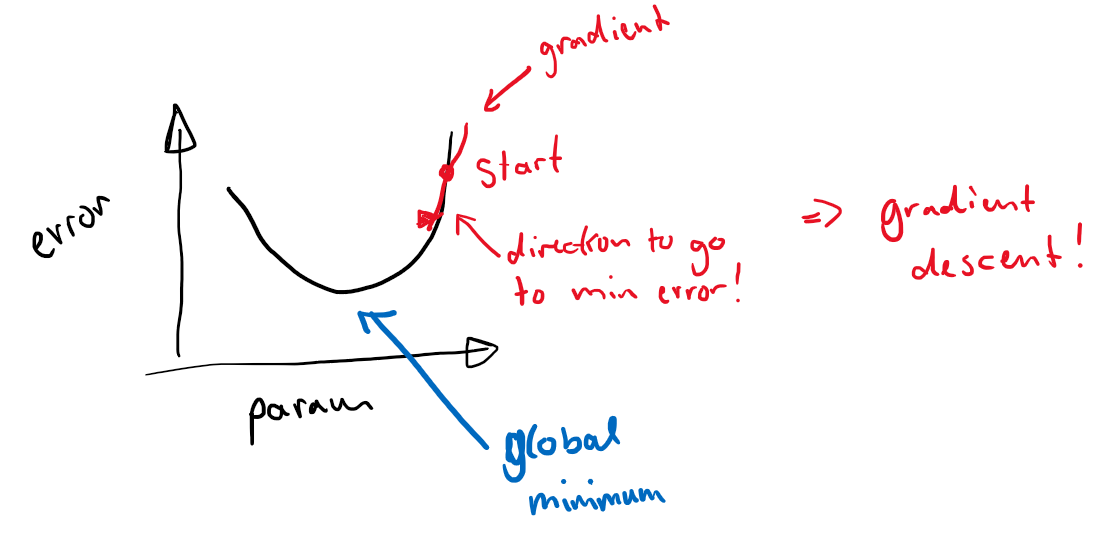

We have two parameters, ```a``` and ```b``` to be minimized:

$$ E = \frac{1}{N} \sum_i^N (y_i - \hat{y}_i)^2, $$
$$ \hat{y} = a \cdot x + b $$

Now we can determine the gradient for a and b by using the partial derivate of E in respect to a and b:

$$ \frac{dE}{da} = \frac{-2}{N} \sum_i^N (y_i - a \cdot x_i - b) \cdot x_i $$ 
$$ \frac{dE}{db} = \frac{-2}{N} \sum_i^N (y_i - a \cdot x_i - b) \cdot 1 $$ 

(0.09555765860065789, -6.6501013781606035, 69.59255255459786)

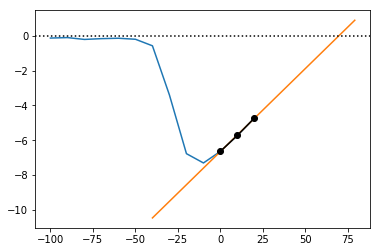

In [43]:
# Gradient descent is an iterative procedure, define iterations:
iterations = 10000
# Define a learning rate, how much you use the gradient to change a and b (lr << 1)
lr = 0.001

# Save the error for each step, should get smaller with iterations
err = []

# Init your parameters (randomly)
a = 1
b = 2

# Iterate
for i in range(iterations):
    # Define your gradients
    gradient_a = -2/len(x) * ((y - (a * x + b)) * x).sum()
    gradient_b = -2/len(x) * ((y - (a * x + b))).sum()
    
    # Apply the gradient
    a = a - lr * gradient_a
    b = b - lr * gradient_b
    

    # Store MSE
    err.append(((y-a*x-b)**2).sum())

# Plot result
    
xs = np.arange(-40, 80)
plt.plot(V, I)
plt.plot(xs, a*xs+b)
plt.plot(x, y, c='k', marker='o')
plt.axhline(0, ls=':', c='k')
        
# Show slope and intercept for gradient descent
# and the estimated E_rev --> almost the same!
a, b, -b/a

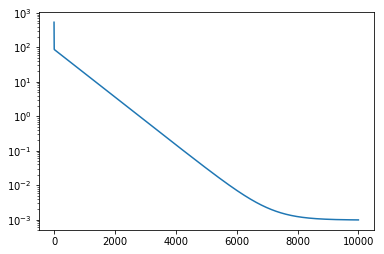

In [44]:
plt.plot(err)
plt.yscale("log")

## Momentum

Can we speed up the convergence? Yes! By using the momentum, i.e. the gradient information from the prev. step to move faster to the minimum!

(0.09573486661598617, -6.653047782249279, 69.49451142953102)

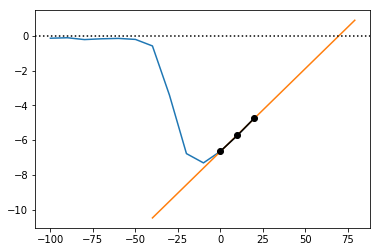

In [45]:
# Gradient descent is an iterative procedure, define iterations:
iterations = 10000
# Define a learning rate, how much you use the gradient to change a and b (lr << 1)
lr = 0.001

# Save the error for each step, should get smaller with iterations
err_m = []

# Init your parameters (randomly)
a = 1
b = 2

####################
## MOMENTUM
####################
momentum = 0.9 # 0 would be identical with previous method
past_gradient_a = 0
past_gradient_b = 0

# Iterate
for i in range(iterations):
    # Define your gradients
    gradient_a = -2/len(x) * ((y - (a * x + b)) * x).sum()
    gradient_b = -2/len(x) * ((y - (a * x + b))).sum()
    
    # Apply the gradient and the past gradient with a scalar factor!
    a = a - lr * (gradient_a + momentum * past_gradient_a)
    b = b - lr * (gradient_b + momentum * past_gradient_b)
    
    past_gradient_a = gradient_a
    past_gradient_b = gradient_b
    
    # Store MSE for momentum
    err_m.append(((y-a*x-b)**2).sum())

# Plot result
    
xs = np.arange(-40, 80)
plt.plot(V, I)
plt.plot(xs, a*xs+b)
plt.plot(x, y, c='k', marker='o')
plt.axhline(0, ls=':', c='k')
        
# Show slope and intercept for gradient descent
# and the estimated E_rev --> almost the same!
a, b, -b/a

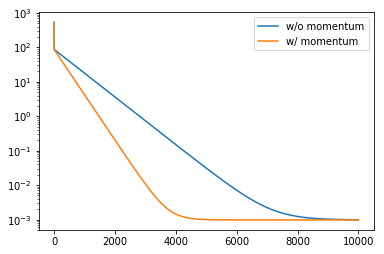

In [46]:
plt.plot(err, label="w/o momentum")
plt.plot(err_m, label="w/ momentum")
plt.legend()
plt.yscale("log")

### Increasing the learning rate vs momentum:

Disclaimer: in this EASY and almost TRIVIAL case, it is not too much different, because the gradient doesn't move in directions! In this case, adapting the lr has the SAME effect as momentum, but on higher, non-linear problems, momentum DOES help!

(0.09573486525033531, -6.653047759542861, 69.49451218368492)

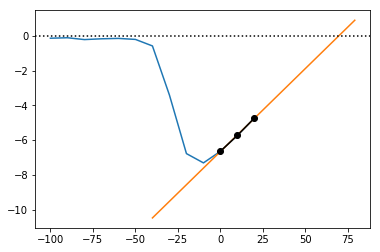

In [47]:
# Gradient descent is an iterative procedure, define iterations:
iterations = 10000
# Define a learning rate, how much you use the gradient to change a and b (lr << 1)
lr = 0.001 * (1 + 0.9)

# Save the error for each step, should get smaller with iterations
err_incr_lr = []

# Init your parameters (randomly)
a = 1
b = 2

# Iterate
for i in range(iterations):
    # Define your gradients
    gradient_a = -2/len(x) * ((y - (a * x + b)) * x).sum()
    gradient_b = -2/len(x) * ((y - (a * x + b))).sum()
    
    # Apply the gradient
    a = a - lr * gradient_a
    b = b - lr * gradient_b
    

    # Store MSE
    err_incr_lr.append(((y-a*x-b)**2).sum())

# Plot result
    
xs = np.arange(-40, 80)
plt.plot(V, I)
plt.plot(xs, a*xs+b)
plt.plot(x, y, c='k', marker='o')
plt.axhline(0, ls=':', c='k')
        
# Show slope and intercept for gradient descent
# and the estimated E_rev --> almost the same!
a, b, -b/a

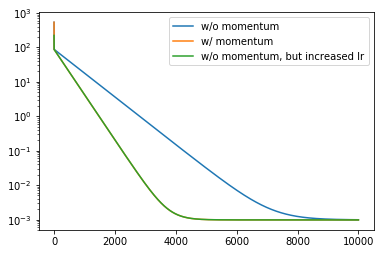

In [48]:
plt.plot(err, label="w/o momentum")
plt.plot(err_m, label="w/ momentum")
plt.plot(err_incr_lr, label="w/o momentum, but increased lr")
plt.legend()
plt.yscale("log")